In [ ]:
pip install h5py tensorflow scikit-learn

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import h5py
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from tensorflow.keras.callbacks import ModelCheckpoint
from skimage.transform import resize


def load_and_preprocess_data(file_paths, target_size=(128, 128)):
    images = []
    labels = []
    tumor_masks = []

    for file_path in file_paths:
        with h5py.File(file_path, 'r') as file:
            data = file['cjdata']
            image = np.array(data['image'], dtype=np.float32) / 255.0
            label = data['label'][0, 0] - 1  # Convert labels to 0-indexing
            tumor_mask = np.array(data['tumorMask'], dtype=np.float32)

            # Resize the image to the target size
            image_resized = resize(image, target_size, anti_aliasing=True)
            mask_resized = resize(tumor_mask, target_size, anti_aliasing=True)

            images.append(image_resized)
            labels.append(label)
            tumor_masks.append(mask_resized)

    # Convert to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)
    tumor_masks = np.array(tumor_masks)

    # Ensure the images have the correct shape
    images = images.reshape(images.shape[0], target_size[0], target_size[1], 1)
    tumor_masks = tumor_masks.reshape(tumor_masks.shape[0], target_size[0], target_size[1], 1)

    return images, labels ,tumor_masks

# Get the list of file paths in the Google Drive folder
drive_folder = '/content/drive/MyDrive/figshare_dataset/data/'
file_paths = [drive_folder + f'{i}.mat' for i in range(1, 3065)]  # Assuming files are named 1.mat to 3064.mat

# Load and preprocess the data
images, labels, segmentation_masks = load_and_preprocess_data(file_paths)


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

# Define the CNN model
model = Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {test_acc}')



Epoch 1/20
62/62 [==============================] - 176s 3s/step - loss: 0.8429 - accuracy: 0.6724 - val_loss: 0.5405 - val_accuracy: 0.7536
Epoch 2/20
62/62 [==============================] - 164s 3s/step - loss: 0.4405 - accuracy: 0.7990 - val_loss: 0.3782 - val_accuracy: 0.8432
Epoch 3/20
62/62 [==============================] - 172s 3s/step - loss: 0.3409 - accuracy: 0.8551 - val_loss: 0.3098 - val_accuracy: 0.8697
Epoch 4/20
62/62 [==============================] - 175s 3s/step - loss: 0.2493 - accuracy: 0.8908 - val_loss: 0.3542 - val_accuracy: 0.8473
Epoch 5/20
62/62 [==============================] - 175s 3s/step - loss: 0.2129 - accuracy: 0.9061 - val_loss: 0.3802 - val_accuracy: 0.8839
Epoch 6/20
62/62 [==============================] - 175s 3s/step - loss: 0.2031 - accuracy: 0.9148 - val_loss: 0.3862 - val_accuracy: 0.8676
Epoch 7/20
62/62 [==============================] - 174s 3s/step - loss: 0.1654 - accuracy: 0.9281 - val_loss: 0.4014 - val_accuracy: 0.8758
Epoch 8/20
62

In [ ]:
# Split the data into training and testing sets
X_train_seg, X_test_seg, y_train_seg, y_test_seg = train_test_split(images, segmentation_masks, test_size=0.2, random_state=42)

# Build a U-Net model for segmentation
def unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Decoder
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    up1 = layers.UpSampling2D(size=(2, 2))(conv2)

    output = layers.Conv2D(1, 1, activation='sigmoid')(up1)

    model = models.Model(inputs, output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the U-Net model
input_shape = (128, 128, 1)  # Assuming images are resized to 128x128
unet = unet_model(input_shape)

# Checkpoint to save the best model during training
checkpoint = ModelCheckpoint('unet_brain_tumor_segmentation.h5', save_best_only=True)

# Train the U-Net model for segmentation
unet.fit(X_train_seg, y_train_seg, epochs=10, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

# Evaluate the U-Net model on the test set
test_loss, test_acc = unet.evaluate(X_test_seg, y_test_seg)
print(f'Test Accuracy: {test_acc}')


Epoch 1/10
62/62 [==============================] - 402s 6s/step - loss: 0.1657 - accuracy: 0.9608 - val_loss: 0.0744 - val_accuracy: 0.9748
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 391s 6s/step - loss: 0.0711 - accuracy: 0.9747 - val_loss: 0.0692 - val_accuracy: 0.9748
Epoch 3/10
62/62 [==============================] - 388s 6s/step - loss: 0.0715 - accuracy: 0.9747 - val_loss: 0.0700 - val_accuracy: 0.9748
Epoch 4/10
62/62 [==============================] - 381s 6s/step - loss: 0.0688 - accuracy: 0.9747 - val_loss: 0.0710 - val_accuracy: 0.9748
Epoch 5/10
62/62 [==============================] - 379s 6s/step - loss: 0.0686 - accuracy: 0.9747 - val_loss: 0.0724 - val_accuracy: 0.9748
Epoch 6/10
62/62 [==============================] - 364s 6s/step - loss: 0.0692 - accuracy: 0.9747 - val_loss: 0.0671 - val_accuracy: 0.9748
Epoch 7/10
62/62 [==============================] - 380s 6s/step - loss: 0.0672 - accuracy: 0.9747 - val_loss: 0.0664 - val_accuracy: 0.9748
Epoch 8/10
62/62 [==============================] - 377s 6s/step - loss: 0.0664 - accuracy: 0.9747 - val_loss: 0.0654 - val_accuracy: 0.9748
Epoch 9/10
62/62 [======

1/1 [==============================] - 0s 320ms/step


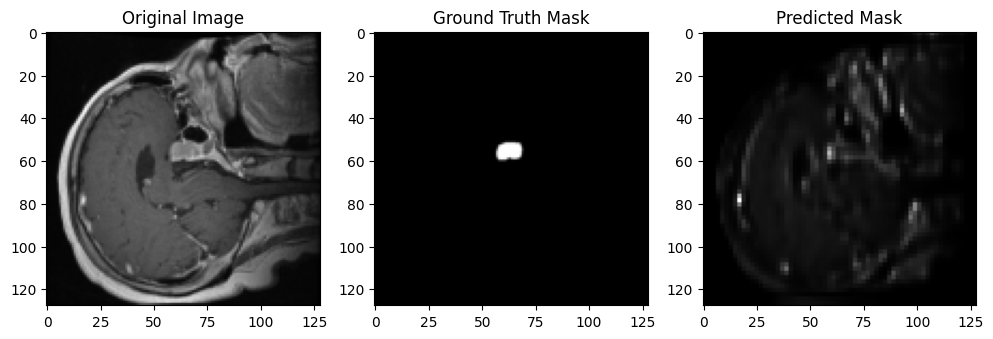

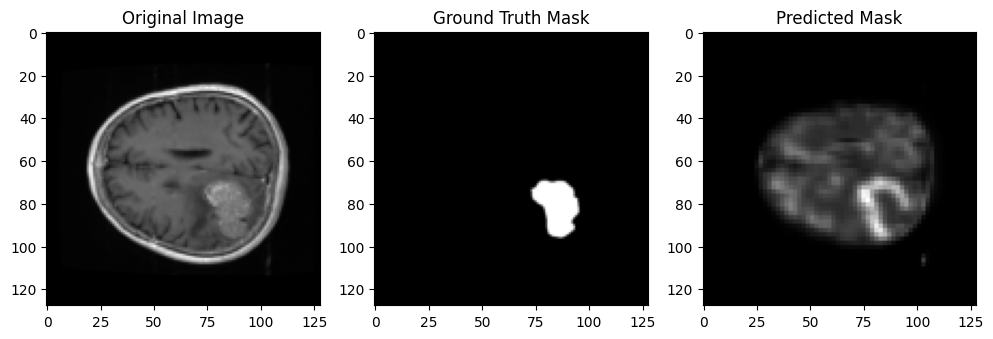

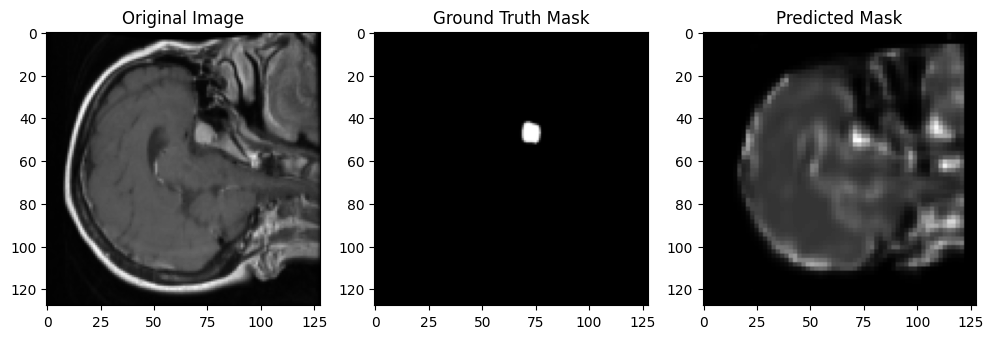

In [ ]:
# Make predictions on a few test samples
import matplotlib.pyplot as plt
num_samples = 3
test_samples = X_test_seg[:num_samples]
ground_truth_masks = y_test_seg[:num_samples]
predicted_masks = unet.predict(test_samples)

# Visualization
for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(test_samples[i, ..., 0], cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_masks[i, ..., 0], cmap='gray')
    plt.title('Ground Truth Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[i, ..., 0], cmap='gray')
    plt.title('Predicted Mask')

    plt.show()